# Flu Shot Learnign - Machine Learning Final Project

To run this colab, it is required to have the competition's data files in the following manner: 
>*googleDriveRoot*/APC/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
# make the plots show in ipython
%matplotlib inline 
import matplotlib.pyplot as plt

# Project data in google drive
DATA_PATH = Path.cwd()/"drive"/"MyDrive"/"APC"/"data";
print(DATA_PATH);

features_train = pd.read_csv(
    DATA_PATH/"training_set_features.csv",
    index_col="respondent_id"
)

labels_train = pd.read_csv(
    DATA_PATH/"training_set_labels.csv",
    index_col="respondent_id"
)

/content/drive/MyDrive/APC/data


In [ ]:
# View the training features
print("features_train.shape", features_train.shape);
features_train.head()

# View the training labels
print("labels_train.shape", labels_train.shape)
labels_train.head()

# no error, no problem
np.testing.assert_array_equal(features_train.index.values, labels_train.index.values)

features_train.shape (26707, 35)
labels_train.shape (26707, 2)


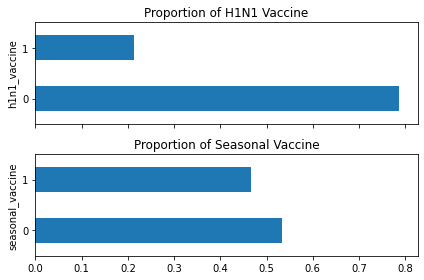

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_train.shape[0]

(labels_train['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_train['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

For seasonal vaccines, the classes are pretty much balenced. But this is not the case for H1N1, where roughly 20% of people got the shot.

In [ ]:
pd.crosstab(
    labels_train["h1n1_vaccine"], 
    labels_train["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [ ]:
# Phi Coefficient is the same as Pearson for two binary variables
(labels_train["h1n1_vaccine"]
     .corr(labels_train["seasonal_vaccine"], method="pearson")
)

0.37714265306144495

These two variables have a phi coefficient of 0.37, indicating a moderate positive correlation. We can see that in the cross-tabulation as well. Most people who got an H1N1 flu vaccine also got the seasonal flu vaccine. While a minority of people who got the seasonal vaccine got the H1N1 vaccine, they got the H1N1 vaccine at a higher rate than those who did not get the seasonal vaccine.

In [ ]:
# Join both features and Labels
joined_train = features_train.join(labels_train)
print(joined_train.shape)
joined_train.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [ ]:
counts = (joined_train[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


***Olá, Jorge. espero que estejas a gostar do documento que estamos a criar.
        Inicialmente juntamos as features que são os dados relativos a cada id, com as labels a ver se tomaram ou não as respetivas vacinas. Agora estamos a comparar a procupação relativamente à H1N1 e a ver se esta relacionado com a toma da mesma vacina. É este o nosso ponto de situação, bom trabalho!***

Pela análise dos dados da tabela, é dificil tirar grandes conclusões. Analisando apenas os valores num gráfico com a sua frequência absoluta neste caso é redundante visto que não conseguimos chegar a nenhuma conclusão. O pedro teve a ideia de usarmos percentagens e conseguimos chegar a uma conclusão. Verificamos que, com o aumento do grau de preocupação, a percentagem de pessoas que tomaram a vacina aumentou.


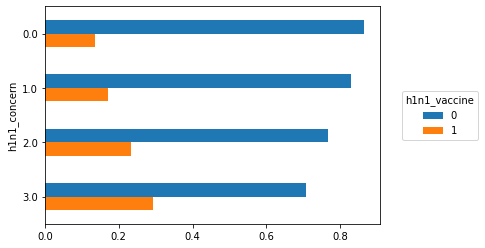

In [ ]:
h1n1_concern_counts = counts.sum(axis='columns')
h1n1_concern_counts
props = counts.div(h1n1_concern_counts, axis='index')
props
ax = props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)